In [1]:
import time
import numpy as np
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import requests
import inspect
import glob
import os
import matplotlib.colors as mcolors
import threading
from cobra import Model, Reaction, Metabolite
from cobra.sampling import ACHRSampler
from cobra.sampling import OptGPSampler
import seaborn as sns


In [2]:
# functions


def fetch_experimental_data(genes):
    url = "https://websvc.biocyc.org/getframe-tab?ECOLI&GENE-ESSENTIALITY"
    headers = {
        'Content-Type': 'application/json',
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.text.splitlines()
        experimental_data = {}
        for line in data:
            parts = line.split("\t")
            if parts[0] in genes:
                experimental_data[parts[0]] = float(parts[2]) if parts[2] != 'None' else None
        return experimental_data
    else:
        print(response)
        print("Failed to fetch data from BioCyc")
        return {}


def plot_growth_rates_transposed(df):
    genes = df['gene']
    growth_columns = [col for col in df.columns if col != 'gene']

    growth_matrix = df[growth_columns].values.T

    cmap = mcolors.ListedColormap(['red', 'green'])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

    fig, ax = plt.subplots(figsize=(len(genes) / 5, len(growth_columns) / 5))

    cax = ax.pcolormesh(growth_matrix, cmap=cmap, norm=norm, edgecolors='w', linewidth=2)

    ax.set_xticks(np.arange(len(genes)) + 0.5, minor=False)
    ax.set_xticklabels(genes, rotation=90, ha="right")
    ax.set_yticks(np.arange(len(growth_columns)) + 0.5, minor=False)
    ax.set_yticklabels(growth_columns)

    ax.xaxis.tick_bottom()
    ax.set_xlabel('Genes', labelpad=30)

    plt.ylabel('Growth Rate Columns')
    plt.title('Gene Growth Rates (Transposed)', pad=20)

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Does not grow',
                              markerfacecolor='red', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Grows',
                              markerfacecolor='green', markersize=10)]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.show()
def get_bools(row):
    bools = []
    for i in row:
        if isinstance(i,bool):
            bools.append(i)
    return bools

def true_pos_check(row):
    bools = get_bools(row)
    if bools[0] == bools[1] == True:
        return True
    return False

def true_neg_check(row):
    bools = get_bools(row)
    if bools[0] == bools[1] == False:
        return True
    return False
    
def false_pos_check(row):
    bools = get_bools(row)
    if bools[0] == False and bools[1] == True:
        return True
    return False
    
def false_neg_check(row):
    bools = get_bools(row)
    if bools[0] == True and bools[1] == False:
        return True
    return False
    


def plot_growth_rates(df):
    genes = df['gene']
    growth_columns = [col for col in df.columns if col != 'gene']

    growth_matrix = df[growth_columns].values

    cmap = mcolors.ListedColormap(['red', 'green'])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
    fig_s_w=len(growth_columns) / 4
    fig_size_h = len(genes) // 5
    if fig_s_w <20:
        fig_s_w =20
    if fig_size_h <20:
        fig_size_h =20
    fig, ax = plt.subplots(figsize=(fig_s_w,fig_size_h ))
  
    cax = ax.pcolormesh(growth_matrix, cmap=cmap, norm=norm, edgecolors='black', linewidth=0.2)

    ax.set_xticks(np.arange(len(growth_columns)) + 0.5, minor=False)
    ax.set_xticklabels(growth_columns, rotation=90, ha="right")
    ax.set_yticks(np.arange(len(genes)) + 0.5, minor=False)
    ax.set_yticklabels(genes)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Growth Rate Columns', labelpad=10)

    plt.ylabel('Genes', labelpad=30)
    plt.title('Gene Growth Rates', pad=20)

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Not grow',
                              markerfacecolor='red', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Grows',
                              markerfacecolor='green', markersize=10)]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), frameon=False)

    plt.tight_layout(pad=5)
    plt.show()


def instance_has_subsystem(cls):
    try:
        instance = cls()
        return hasattr(instance, 'subsystem')
    except:
        return False


def calculate_growth_rate(final_od, initial_od=0.000001, time=22):
    if final_od > 0 and initial_od > 0 and time > 0:
        return (np.log(final_od / initial_od) / time) / 60
    else:
        return 0


def get_from_file_msb4(file_name):
    data_frame = pd.read_excel(file_name, skiprows=3)
    data_frame.rename(columns={data_frame.columns[0]: 'ECK number', data_frame.columns[1]: 'gene'}, inplace=True)
    selected_columns = data_frame[['gene', "LB_22hr"]].copy()
    selected_columns.rename(columns={"LB_22hr": 'growth_rate_file_1'}, inplace=True)
    selected_columns['growth_rate_file_1'] = pd.to_numeric(selected_columns['growth_rate_file_1'], errors='coerce')

    selected_columns['growth_rate_file_1'].fillna(0)

    selected_columns['growth_rate_file_1'] = selected_columns['growth_rate_file_1'].apply(
        lambda x: 1 if float(x) > 0 else 0)
    return selected_columns


def get_from_file_MSB14(file_name):
    data_frame = pd.read_excel(file_name, sheet_name="Normalized data")
    selected_columns = data_frame[['Gene deletion', "alpha_max (min-1) ( maximum growth rate)"]].copy()
    selected_columns.rename(
        columns={'Gene deletion': 'gene', "alpha_max (min-1) ( maximum growth rate)": 'growth_rate_file_2'},
        inplace=True)
    selected_columns['growth_rate_file_2'] = pd.to_numeric(selected_columns['growth_rate_file_2'], errors='coerce')
    selected_columns['growth_rate_file_2'].fillna(0)

    selected_columns['growth_rate_file_2'] = selected_columns['growth_rate_file_2'].apply(lambda x: 1 if x > 0 else 0)
    return selected_columns


def safe_convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return 0.0


def get_uniques(comparison_df_differ_t):
    def all_values_same(row):
        return (row[growth_columns].nunique() == 1)

    growth_columns = [col for col in comparison_df_differ_t.columns if col != 'gene']
    comparison_df_differ_t = comparison_df_differ_t[~comparison_df_differ_t.apply(all_values_same, axis=1)]
    return comparison_df_differ_t


def get_bigg_models():
    url = 'http://bigg.ucsd.edu/api/v2/models'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['results']
    else:
        raise Exception(f"Failed to retrieve models from BiGG database. Status code: {response.status_code}")


def single_gene_knockout(model_ecoli, gene_id, initial_OD=0.3, time_interval=16):
    """
    Perform a single gene knockout and return the OD after a specified time interval (default 22 hours).

    Parameters:
    - model_ecoli: COBRApy model of E. coli
    - gene_id: ID of the gene to knock out
    - initial_OD: Initial optical density (default is 0.1)
    - time_interval: Time interval in hours for which to calculate OD (default is 22 hours)

    Returns:
    - final_OD: Optical density after the specified time interval
    """

    with model_ecoli:
        model_ecoli.genes.get_by_id(gene_id).knock_out()
        solution = model_ecoli.optimize()
        growth_rate = solution.objective_value

        # final_OD = initial_OD * np.exp(growth_rate * time_interval)

        return growth_rate


In [3]:
# classes
class OptThread(threading.Thread):
    def __init__(self, test_model_obj):
        super().__init__()
        self.test_model_obj = test_model_obj
        self.result = None
        self.name = None
        self.done = 0
        self.model_filename = None
        self.test_model = None
        self._lock = None  
        self.loaded = False

    def run(self):

        self.name = self.test_model_obj["bigg_id"]
        files = glob.glob("pickled/*.pkl")  

        for f in files:
            filename = os.path.basename(f)
            file_name_without_ext = os.path.splitext(filename)[0]

            if file_name_without_ext == self.name:
                with open(f, 'rb') as file:
                    obj = pickle.load(file)
                    self.name = obj["name"]
                    self.knockout_results = obj["knockout_results"]
                self.loaded = True

        self.model_filename = "models/" + self.test_model_obj["bigg_id"] + ".xml"
        print(self.model_filename, "starting to opt")
        self.test_model = cobra.io.read_sbml_model(self.model_filename)

        self.genes_to_knockout = [x.id for x in self.test_model.genes]
        self.genes_to_knockout_names = [x.name for x in self.test_model.genes]
        self.lb_medium_file = "data/pone.0236890.s001.ods"
        self.lb_medium_df = pd.read_excel(self.lb_medium_file, engine="odf", sheet_name="STEP 6")
        self.LB_medium = {}

        for index, row in self.lb_medium_df.iterrows():
            self.exchange_reaction = row['EXCHANGE REACTION']
            self.concentration = row['MOLECULAR CONCENTRATION IN TOTAL']
            if pd.notna(self.exchange_reaction) and pd.notna(self.concentration):
                self.LB_medium[self.exchange_reaction] = -self.concentration 
        self.test_model.medium.update(self.LB_medium)
        if self.loaded == True:
            for g in self.genes_to_knockout_names:
                if g not in self.knockout_results.keys():
                    self.loaded = False
                    print(f"problem in the knockout loaded result in {self.name}\n"*10)
                    break

        if self.loaded == False:
            self.knockout_results = {
                self.test_model.genes.get_by_id(gene).name: single_gene_knockout(self.test_model, gene)
                for gene in
                self.genes_to_knockout}

        print(f"Single Gene Knockout Results {self.test_model_obj["bigg_id"]}:", end="\t")
        print(len(self.knockout_results))
        self.result = self.knockout_results
        self.done = 1
        if self.loaded == True:
            return
        print(f"pickelign the instance {self.name}.pkl")
        if not os.path.exists("pickled/"):
            os.makedirs("pickled/")

        file_path = os.path.join("pickled/", f"{self.name}.pkl")

        with open(file_path, 'wb') as file:
            pickle.dump({"name": self.name, "knockout_results": self.knockout_results}, file)
        print("\tpickling completed")


class DownloadThread(threading.Thread):
    def __init__(self, test_model_obj):
        super().__init__()
        self.test_model_obj = test_model_obj

    def run(self):
        model_filename = "models/" + self.test_model_obj["bigg_id"] + ".xml"
        model_url = "http://bigg.ucsd.edu/static/models/" + self.test_model_obj["bigg_id"] + ".xml"
        if not os.path.exists(model_filename):
            print(f"model {model_filename} not exists")
            response = requests.get(model_url)
            response.raise_for_status() 

            with open(model_filename, 'wb') as file:
                file.write(response.content)
        else:
            print(f"model {model_filename} exists. not downloading ")



In [4]:
model = Model('toy_model')

reactions = {}

In [5]:
# Reaction v1: A --> B
reactions['v1'] = Reaction('v1')
reactions['v1'].lower_bound = 1
reactions['v1'].upper_bound = 1.2

# Reaction v2: B --> C
reactions['v2'] = Reaction('v2')
reactions['v2'].lower_bound = 1
reactions['v2'].upper_bound = 1.2

# Reaction v3: B --> D
reactions['v3'] = Reaction('v3')
reactions['v3'].lower_bound = 0
reactions['v3'].upper_bound = 1.2

# Reaction v4: C --> E
reactions['v4'] = Reaction('v4')
reactions['v4'].lower_bound = 0
reactions['v4'].upper_bound = 1.2

# Reaction v5: D --> E
reactions['v5'] = Reaction('v5')
reactions['v5'].lower_bound = 0
reactions['v5'].upper_bound = 1.2

# Reaction v6: E --> F
reactions['v6'] = Reaction('v6')
reactions['v6'].lower_bound = 0.3
reactions['v6'].upper_bound = 0.5

# Reaction v7: F --> G
reactions['v7'] = Reaction('v7')
reactions['v7'].lower_bound = 0.3
reactions['v7'].upper_bound = 0.5

# Reaction v8: G --> H
reactions['v8'] = Reaction('v8')
reactions['v8'].lower_bound = 0
reactions['v8'].upper_bound = 1000  # Arbitrarily large upper bound

model.add_reactions([reactions[r] for r in reactions])

In [6]:
A = Metabolite('A', compartment='e')
B = Metabolite('B', compartment='c')
C = Metabolite('C', compartment='c')
D = Metabolite('D', compartment='e')
E = Metabolite('E', compartment='c')

reactions['v1'].add_metabolites({A: 1})
reactions['v2'].add_metabolites({A: -1, B: 1})
reactions['v3'].add_metabolites({B: -1, E: 1})
reactions['v4'].add_metabolites({B: -1, C: 1})
reactions['v5'].add_metabolites({C: -1})
reactions['v6'].add_metabolites({D: 1})
reactions['v7'].add_metabolites({D: -1, E: 1})
reactions['v8'].add_metabolites({E: -1})

In [7]:
results = {}

for reaction_id in reactions:
    model.objective = reactions[reaction_id]
    solution = model.optimize()
    results[reaction_id] = solution.fluxes

table = []

for reaction_id, fluxes in results.items():
    table.append([])
    table[-1].append(f"Obj:Max {reaction_id}:")
    for rxn_id, flux in fluxes.items():
        table[-1].append(f"{rxn_id}: {flux}")
table = np.array(table)
max_cols = []
for item in table:
    max_col = []
    for i in item:
        max_col.append(len(i))
    max_cols.append(max(max_col))

table = table.transpose()
last_row = table[-1]
for item in zip(table, max_cols):
    for row in item[0]:
        print(f"{row.ljust(item[1])}", end="  ")
    print()
for row in last_row:
    print(f"{row.ljust(max_cols[-2])}", end="  ")
print()

Obj:Max v1:  Obj:Max v2:  Obj:Max v3:  Obj:Max v4:  Obj:Max v5:  Obj:Max v6:  Obj:Max v7:  Obj:Max v8:  
v1: 1.2      v1: 1.2      v1: 1.2      v1: 1.2      v1: 1.2      v1: 1.2      v1: 1.2      v1: 1.2      
v2: 1.2      v2: 1.2      v2: 1.2      v2: 1.2      v2: 1.2      v2: 1.2      v2: 1.2      v2: 1.2      
v3: 1.2      v3: 1.2      v3: 1.2      v3: 0.0      v3: 0.0      v3: 0.0      v3: 0.0      v3: 1.2      
v4: 0.0      v4: 0.0      v4: 0.0      v4: 1.2      v4: 1.2      v4: 1.2      v4: 1.2      v4: 0.0      
v5: 0.0      v5: 0.0      v5: 0.0      v5: 1.2      v5: 1.2      v5: 1.2      v5: 1.2      v5: 0.0      
v6: 0.3      v6: 0.3      v6: 0.3      v6: 0.3      v6: 0.3      v6: 0.5      v6: 0.5      v6: 0.5      
v7: 0.3      v7: 0.3      v7: 0.3      v7: 0.3      v7: 0.3      v7: 0.5      v7: 0.5      v7: 0.5      
v8: 1.5      v8: 1.5      v8: 1.5      v8: 0.3      v8: 0.3      v8: 0.5      v8: 0.5      v8: 1.7      


In [8]:
# add a reaction 
# Reaction v9: C --> E
reactions['v9'] = Reaction('v9')
reactions['v9'].lower_bound = 0
reactions['v9'].upper_bound = 1000  

model.add_reactions([reactions["v9"]])

reactions['v9'].add_metabolites({C: -1, E: 1})
results["v9"] = []

new_result = {}

for reaction_id in reactions:
    model.objective = reactions[reaction_id]
    solution = model.optimize()
    new_result[reaction_id] = solution.fluxes

In [9]:

table = []

for reaction_id, fluxes in new_result.items():
    table.append([])
    table[-1].append(f"Obj:Max {reaction_id}:")
    for rxn_id, flux in fluxes.items():
        string_temp = f"{rxn_id}: n:{flux}"
        try:
            string_temp += f" o:{results[reaction_id][rxn_id]}"
        except:
            pass
        table[-1].append(string_temp)
table = np.array(table)
max_cols = []
for item in table:
    max_col = []
    for i in item:
        max_col.append(len(i))
    max_cols.append(max(max_col))

table = table.transpose()
last_row = table[-1]
print("n is new , o is old")
for item in zip(table, max_cols):
    for row in item[0]:
        print(f"{row.ljust(item[1])}", end="  ")
    print()
for row in last_row:
    print(f"{row.ljust(max_cols[-2])}", end="  ")


n is new , o is old
Obj:Max v1:      Obj:Max v2:      Obj:Max v3:      Obj:Max v4:      Obj:Max v5:      Obj:Max v6:      Obj:Max v7:      Obj:Max v8:      Obj:Max v9:      
v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2 o:1.2  v1: n:1.2        
v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2 o:1.2  v2: n:1.2        
v3: n:1.2 o:1.2  v3: n:1.2 o:1.2  v3: n:1.2 o:1.2  v3: n:0.0 o:0.0  v3: n:0.0 o:0.0  v3: n:0.0 o:0.0  v3: n:0.0 o:0.0  v3: n:0.0 o:1.2  v3: n:0.0        
v4: n:0.0 o:0.0  v4: n:0.0 o:0.0  v4: n:0.0 o:0.0  v4: n:1.2 o:1.2  v4: n:1.2 o:1.2  v4: n:1.2 o:1.2  v4: n:1.2 o:1.2  v4: n:1.2 o:0.0  v4: n:1.2        
v5: n:0.0 o:0.0  v5: n:0.0 o:0.0  v5: n:0.0 o:0.0  v5: n:1.2 o:1.2  v5: n:1.2 o:1.2  v5: n:1.2 o:1.2  v5: n:1.2 o:1.2  v5: n:0.0 o:0.0  v5: n:0.0        
v6: n:0.5 o:0.3  v6: n:0.5 o:0.3  v6: n:0.5 o:0.3  v6: n

In [10]:
model.medium

{'v1': 1.2, 'v6': 0.5}

In [11]:
# stoichiometric matrix
S = cobra.util.array.create_stoichiometric_matrix(model)

metabolites = [met.id for met in model.metabolites]
reactions = [rxn.id for rxn in model.reactions]

df = pd.DataFrame(S, index=metabolites, columns=reactions)

# Print the stoichiometric matrix
print(df)


    v1   v2   v3   v4   v5   v6   v7   v8   v9
A  1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
B  0.0  1.0 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0
E  0.0  0.0  1.0  0.0  0.0  0.0  1.0 -1.0  1.0
C  0.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0 -1.0
D  0.0  0.0  0.0  0.0  0.0  1.0 -1.0  0.0  0.0


In [12]:
recon3d_url = "http://bigg.ucsd.edu/static/models/Recon3D.xml"

# Define the file name to save the downloaded model
model_filename = "models/Recon3D.xml"

if not os.path.exists(model_filename):
    print("model not exists")
    response = requests.get(recon3d_url)
    response.raise_for_status() 

    with open(model_filename, 'wb') as file:
        file.write(response.content)
else:
    print("model exists. not downloading ")
model_recon = cobra.io.read_sbml_model(model_filename)

print(f"Model ID: {model_recon.id}")
print(f"Number of reactions: {len(model_recon.reactions)}")
print(f"Number of metabolites: {len(model_recon.metabolites)}")
print(f"Number of genes: {len(model_recon.genes)}")

model exists. not downloading 
Model ID: Recon3D
Number of reactions: 10600
Number of metabolites: 5835
Number of genes: 2248


In [13]:
S = cobra.util.array.create_stoichiometric_matrix(model_recon)

metabolites = [f"{met.id}" for met in model_recon.metabolites]
reactions = [f"{rxn.id}" for rxn in model_recon.reactions]

df = pd.DataFrame(S, index=metabolites, columns=reactions)
pd.set_option('display.max_columns', None)

styled_df = df.iloc[50:60]

print(styled_df)


             24_25DHVITD3tm  25HVITD3t  COAtl  EX_5adtststerone_e  \
35cgmp_n                0.0        0.0    0.0                 0.0   
5hoxindoa_c             0.0        0.0    0.0                 0.0   
5htrp_e                 0.0        0.0    0.0                 0.0   
1pipdn2c_x              0.0        0.0    0.0                 0.0   
3aib_m                  0.0        0.0    0.0                 0.0   
nadh_x                  0.0        0.0    0.0                 0.0   
2mop_m                  0.0        0.0    0.0                 0.0   
5mthf_e                 0.0        0.0    0.0                 0.0   
Lpipecol_x              0.0        0.0    0.0                 0.0   
nad_x                   0.0        0.0    0.0                 0.0   

             EX_5adtststerones_e  EX_5fthf_e  EX_5htrp_e  EX_5mthf_e  \
35cgmp_n                     0.0         0.0         0.0         0.0   
5hoxindoa_c                  0.0         0.0         0.0         0.0   
5htrp_e                 

In [14]:
# flux sampling
samples = cobra.sampling.sample(model, 1000)
samples.head()

v1        v2        v3        v4        v5        v6        v7  \
0  1.140698  1.140698  0.979523  0.161176  0.127771  0.320550  0.320550   
1  1.078162  1.078162  0.950689  0.127473  0.013618  0.456841  0.456841   
2  1.119465  1.119465  0.213814  0.905651  0.148549  0.433557  0.433557   
3  1.017603  1.017603  0.549012  0.468591  0.062778  0.367940  0.367940   
4  1.167099  1.167099  0.363876  0.803224  0.747885  0.429071  0.429071   

         v8        v9  
0  1.333477  0.033404  
1  1.521386  0.113855  
2  1.404474  0.757102  
3  1.322765  0.405813  
4  0.848286  0.055339

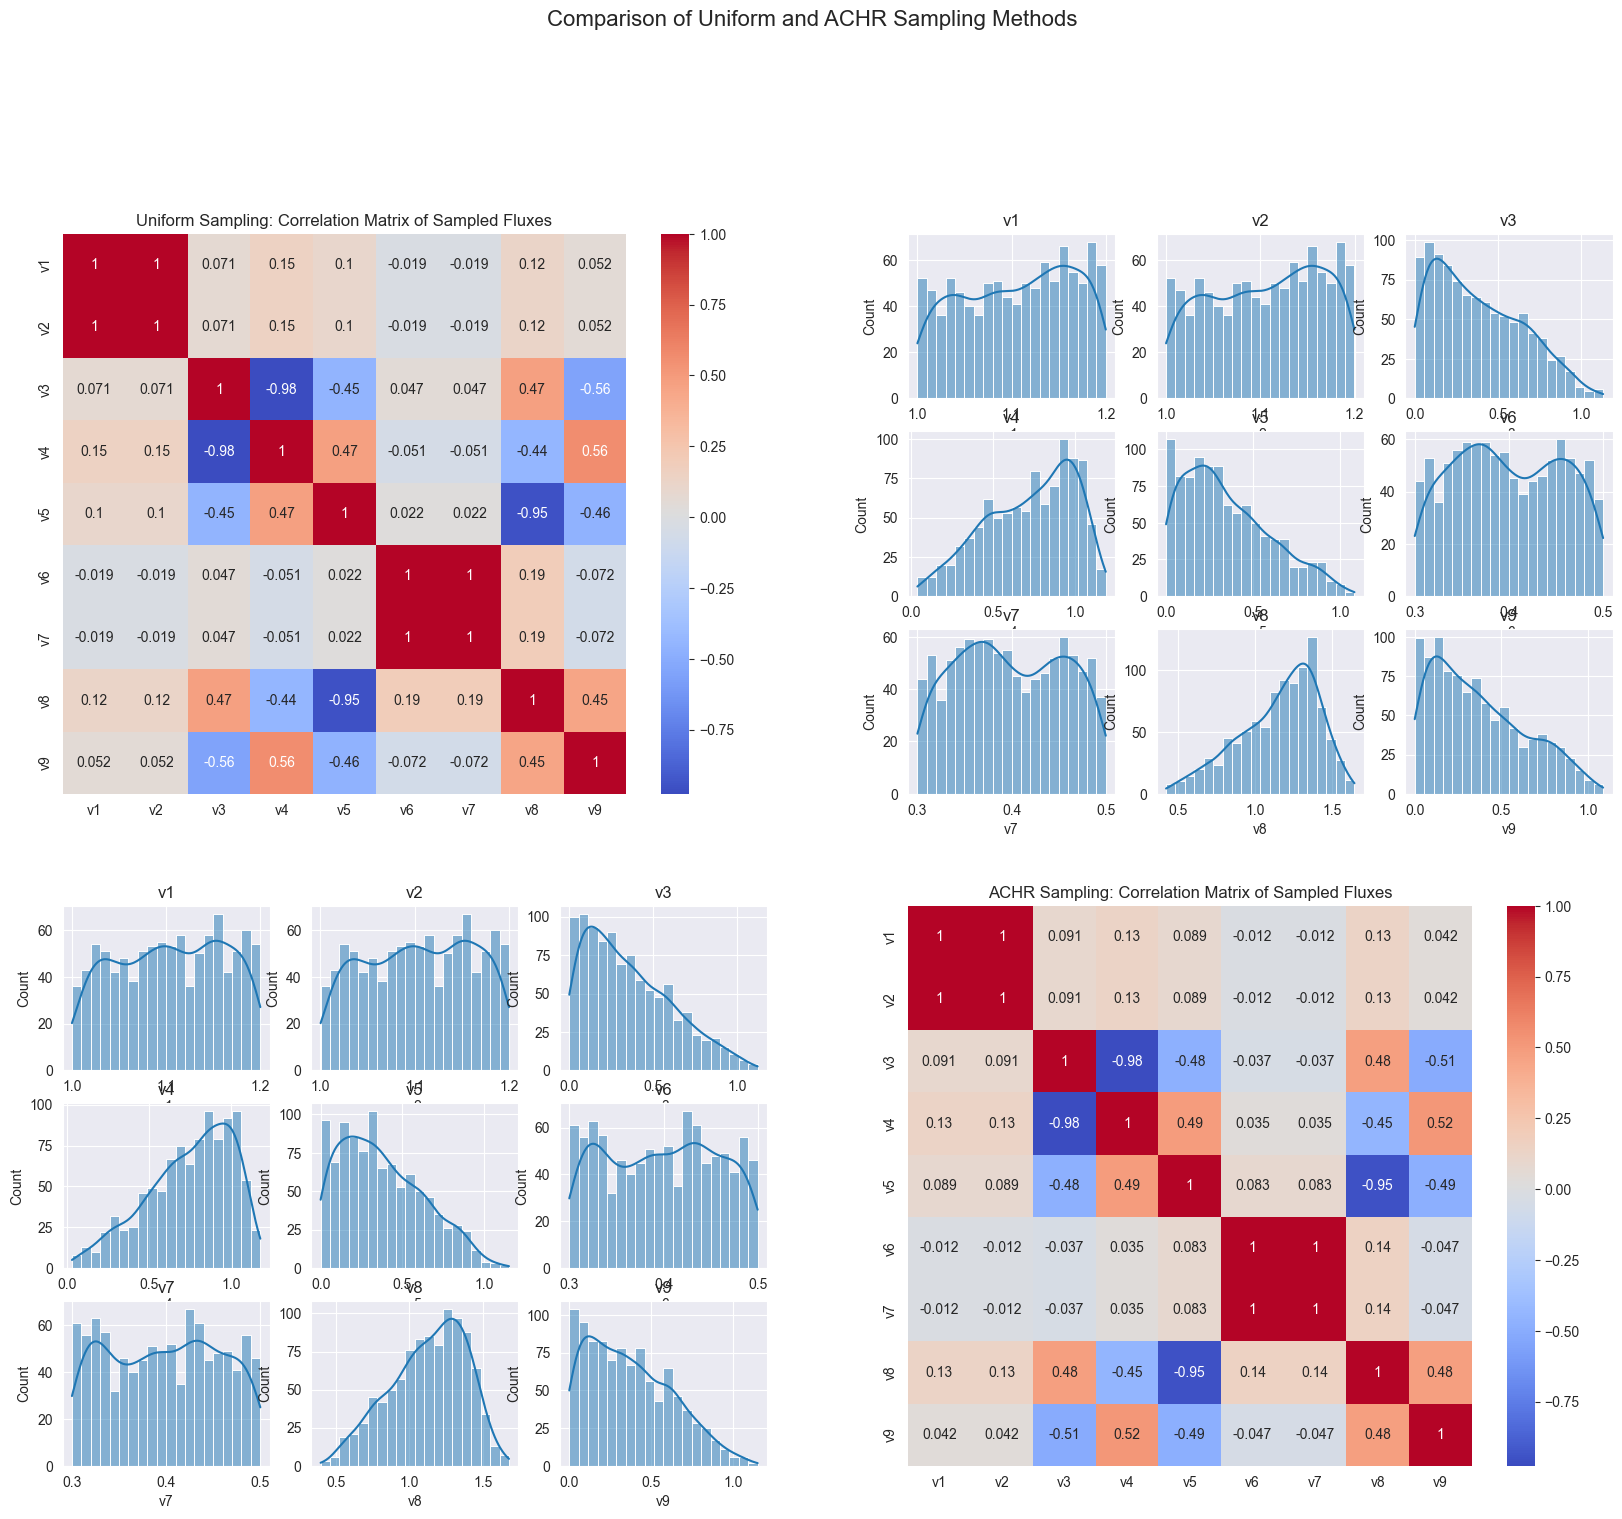

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sampler = OptGPSampler(model, processes=4)
optgp_samples = sampler.sample(1000)

achr_sampler = ACHRSampler(model, thinning=100)
achr_samples = achr_sampler.sample(1000)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.2)

gs_uniform_hist = gs[0, 1].subgridspec(3, 3)
for i, column in enumerate(optgp_samples.columns):
    ax = fig.add_subplot(gs_uniform_hist[i // 3, i % 3])
    sns.histplot(optgp_samples[column], ax=ax, kde=True, bins=20)
    ax.set_title(column)

ax_corr_optgp = fig.add_subplot(gs[0, 0])
corr_optgp = optgp_samples.corr()
sns.heatmap(corr_optgp, annot=True, cmap='coolwarm', ax=ax_corr_optgp)
ax_corr_optgp.set_title('Uniform Sampling: Correlation Matrix of Sampled Fluxes')

gs_achr_hist = gs[1, 0].subgridspec(3, 3)
for i, column in enumerate(achr_samples.columns[:9]):
    ax = fig.add_subplot(gs_achr_hist[i // 3, i % 3])
    sns.histplot(achr_samples[column], ax=ax, kde=True, bins=20)
    ax.set_title(column)

ax_corr_achr = fig.add_subplot(gs[1, 1])
corr_achr = achr_samples.corr()
sns.heatmap(corr_achr, annot=True, cmap='coolwarm', ax=ax_corr_achr)
ax_corr_achr.set_title('ACHR Sampling: Correlation Matrix of Sampled Fluxes')

plt.suptitle('Comparison of Uniform and ACHR Sampling Methods', y=1.02, fontsize=16)
plt.show()


In [16]:
iJO1366_url = "http://bigg.ucsd.edu/static/models/iJO1366.xml"

model_filename = "models/" + iJO1366_url.split("/")[-1]

if not os.path.exists(model_filename):
    print("model not exists")
    response = requests.get(iJO1366_url)
    response.raise_for_status()  

    with open(model_filename, 'wb') as file:
        file.write(response.content)
else:
    print("model exists. not downloading ")

model_ecoli = cobra.io.read_sbml_model(model_filename)

genes_to_knockout = [x.id for x in model_ecoli.genes]
print(genes_to_knockout)

print(model_ecoli.objective)

model exists. not downloading 
['b1377', 'b0241', 'b0929', 'b2215', 'b0653', 'b0655', 'b0118', 'b1276', 'b4032', 'b3359', 'b3528', 'b4033', 'b4035', 'b4034', 'b4036', 'b4213', 'b4123', 'b2835', 'b4138', 'b4077', 'b3503', 'b1064', 'b1747', 'b1539', 'b1748', 'b1090', 'b3475', 'b2836', 'b2563', 'b3553', 'b2578', 'b1533', 'b2019', 'b1134', 'b3735', 'b4067', 'b0446', 'b1623', 'b1096', 'b3739', 'b3732', 'b3737', 'b3733', 'b3734', 'b3738', 'b1009', 'b1812', 'b0180', 'b3360', 'b3731', 'b3736', 'b0954', 'b3665', 'b0347', 'b3654', 'b0312', 'b3580', 'b3714', 'b1093', 'b1095', 'b2323', 'b0474', 'b0120', 'b0827', 'b1397', 'b3857', 'b3856', 'b4214', 'b3806', 'b1245', 'b0030', 'b3551', 'b1246', 'b0775', 'b1329', 'b0933', 'b2393', 'b1247', 'b1244', 'b1386', 'b0366', 'b0367', 'b0004', 'b0934', 'b0365', 'b0936', 'b1192', 'b1216', 'b1243', 'b4266', 'b4132', 'b4265', 'b0159', 'b3942', 'b2708', 'b1732', 'b2964', 'b3197', 'b2406', 'b0411', 'b3196', 'b1094', 'b4481', 'b1270', 'b1927', 'b2874', 'b1992', 'b015

In [17]:
lb_medium_file = "data/pone.0236890.s001.ods"
lb_medium_df = pd.read_excel(lb_medium_file, engine="odf", sheet_name="STEP 6")
LB_medium = {}

for index, row in lb_medium_df.iterrows():
    exchange_reaction = row['EXCHANGE REACTION']
    concentration = row['MOLECULAR CONCENTRATION IN TOTAL']
    if pd.notna(exchange_reaction) and pd.notna(concentration):
        LB_medium[exchange_reaction] = -concentration 

model_ecoli.medium.update(LB_medium)

knockout_results = {model_ecoli.genes.get_by_id(gene).name: single_gene_knockout(model_ecoli, gene) for gene in
                    genes_to_knockout}
print("Single Gene Knockout Results:")
for gene, growth_rate in knockout_results.items():
    print(f"Gene {gene}: Growth rate = {growth_rate}")
print(len(knockout_results))

Single Gene Knockout Results:
Gene ompN: Growth rate = 0.9823718127269743
Gene phoE: Growth rate = 0.9823718127269705
Gene ompF: Growth rate = 0.9823718127269705
Gene ompC: Growth rate = 0.9823718127269705
Gene gltK: Growth rate = 0.9823718127269705
Gene gltI: Growth rate = 0.9823718127269705
Gene acnB: Growth rate = 0.9823718127269705
Gene acnA: Growth rate = 0.9823718127269705
Gene malG: Growth rate = 0.9823718127269705
Gene argD: Growth rate = -3.5759143813219697e-16
Gene dctA: Growth rate = 0.9823718127269803
Gene malF: Growth rate = 0.9823718127269705
Gene malK: Growth rate = 0.9823718127269705
Gene malE: Growth rate = 0.9823718127269705
Gene lamB: Growth rate = 0.9823718127269705
Gene cpdB: Growth rate = 0.9823718127269705
Gene dcuB: Growth rate = 0.9823718127269705
Gene lplT: Growth rate = 0.9823718127269705
Gene dcuA: Growth rate = 0.9823718127269705
Gene gltP: Growth rate = 0.9823718127269705
Gene arsC: Growth rate = 0.9823718127269705
Gene grxB: Growth rate = 0.98237181272697

In [18]:
file_1 = "data/msb4100050-s5.xls"
file_2 = "data/MSB-14-e7573-s004.xlsx"

experimental_data_1 = get_from_file_msb4(file_1)

experimental_data_2 = get_from_file_MSB14(file_2)

simulation_data = pd.DataFrame(list(knockout_results.items()), columns=['gene', 'growth_rate_simulated'])
simulation_data["growth_rate_simulated"] = simulation_data["growth_rate_simulated"].apply(lambda x: 1 if x > 0 else 0)

# experimental_data_1.rename(columns={experimental_data_1.columns[1]: 'growth_rate_file_1'}, inplace=True)

pd_essentials = pd.read_excel("essentialgenes_list.xlsx", skiprows=1)

pd_essentials = pd_essentials[["Gene", "Essential", "Non-essential", "Unclear"]]

pd_essentials["gene"] = pd_essentials["Gene"]
pd_essentials["Essential"] = pd_essentials["Essential"].astype(bool)
pd_essentials["Non-essential"] = pd_essentials["Non-essential"].astype(bool)
pd_essentials = pd_essentials[pd_essentials["Unclear"] == False]
pd_essentials = pd_essentials[["gene", "Essential", "Non-essential"]]

pd_essentials["is_essential_file_can_grow"] = pd_essentials["Essential"].apply(lambda x: 0 if x == True else 1)
thrL_rows = pd_essentials[pd_essentials["gene"] == "aceF"]
print(thrL_rows)
pd_essentials = pd_essentials[["gene", "is_essential_file_can_grow"]]

experimental_data_1 = experimental_data_1[["gene", "growth_rate_file_1"]]

comparison_df = pd.merge(simulation_data, experimental_data_1, on="gene", how="inner")
comparison_df = pd.merge(comparison_df, experimental_data_2, on="gene", how="inner")
comparison_df = pd.merge(comparison_df, pd_essentials, on="gene", how="outer")

print("\nComparison of Simulated and Experimental Done and saving to 'gene_knockout_comparison.csv'")

comparison_df.to_csv("gene_knockout_comparison.csv", index=False)

     gene  Essential  Non-essential  is_essential_file_can_grow
108  aceF       True          False                           0

Comparison of Simulated and Experimental Done and saving to 'gene_knockout_comparison.csv'


      gene  growth_rate_simulated  growth_rate_file_1  growth_rate_file_2  \
19    aceF                    1.0                 1.0                 1.0   
71    alaS                    1.0                 1.0                 1.0   
126   argA                    0.0                 1.0                 1.0   
127   argB                    0.0                 1.0                 1.0   
129   argD                    0.0                 1.0                 1.0   
...    ...                    ...                 ...                 ...   
2647  ubiE                    1.0                 1.0                 1.0   
2648  ubiG                    1.0                 1.0                 1.0   
2649  ubiH                    1.0                 1.0                 1.0   
2652  ubiX                    0.0                 1.0                 1.0   
4139  yrbG                    0.0                 1.0                 1.0   

      is_essential_file_can_grow  
19                           0.0  
71   

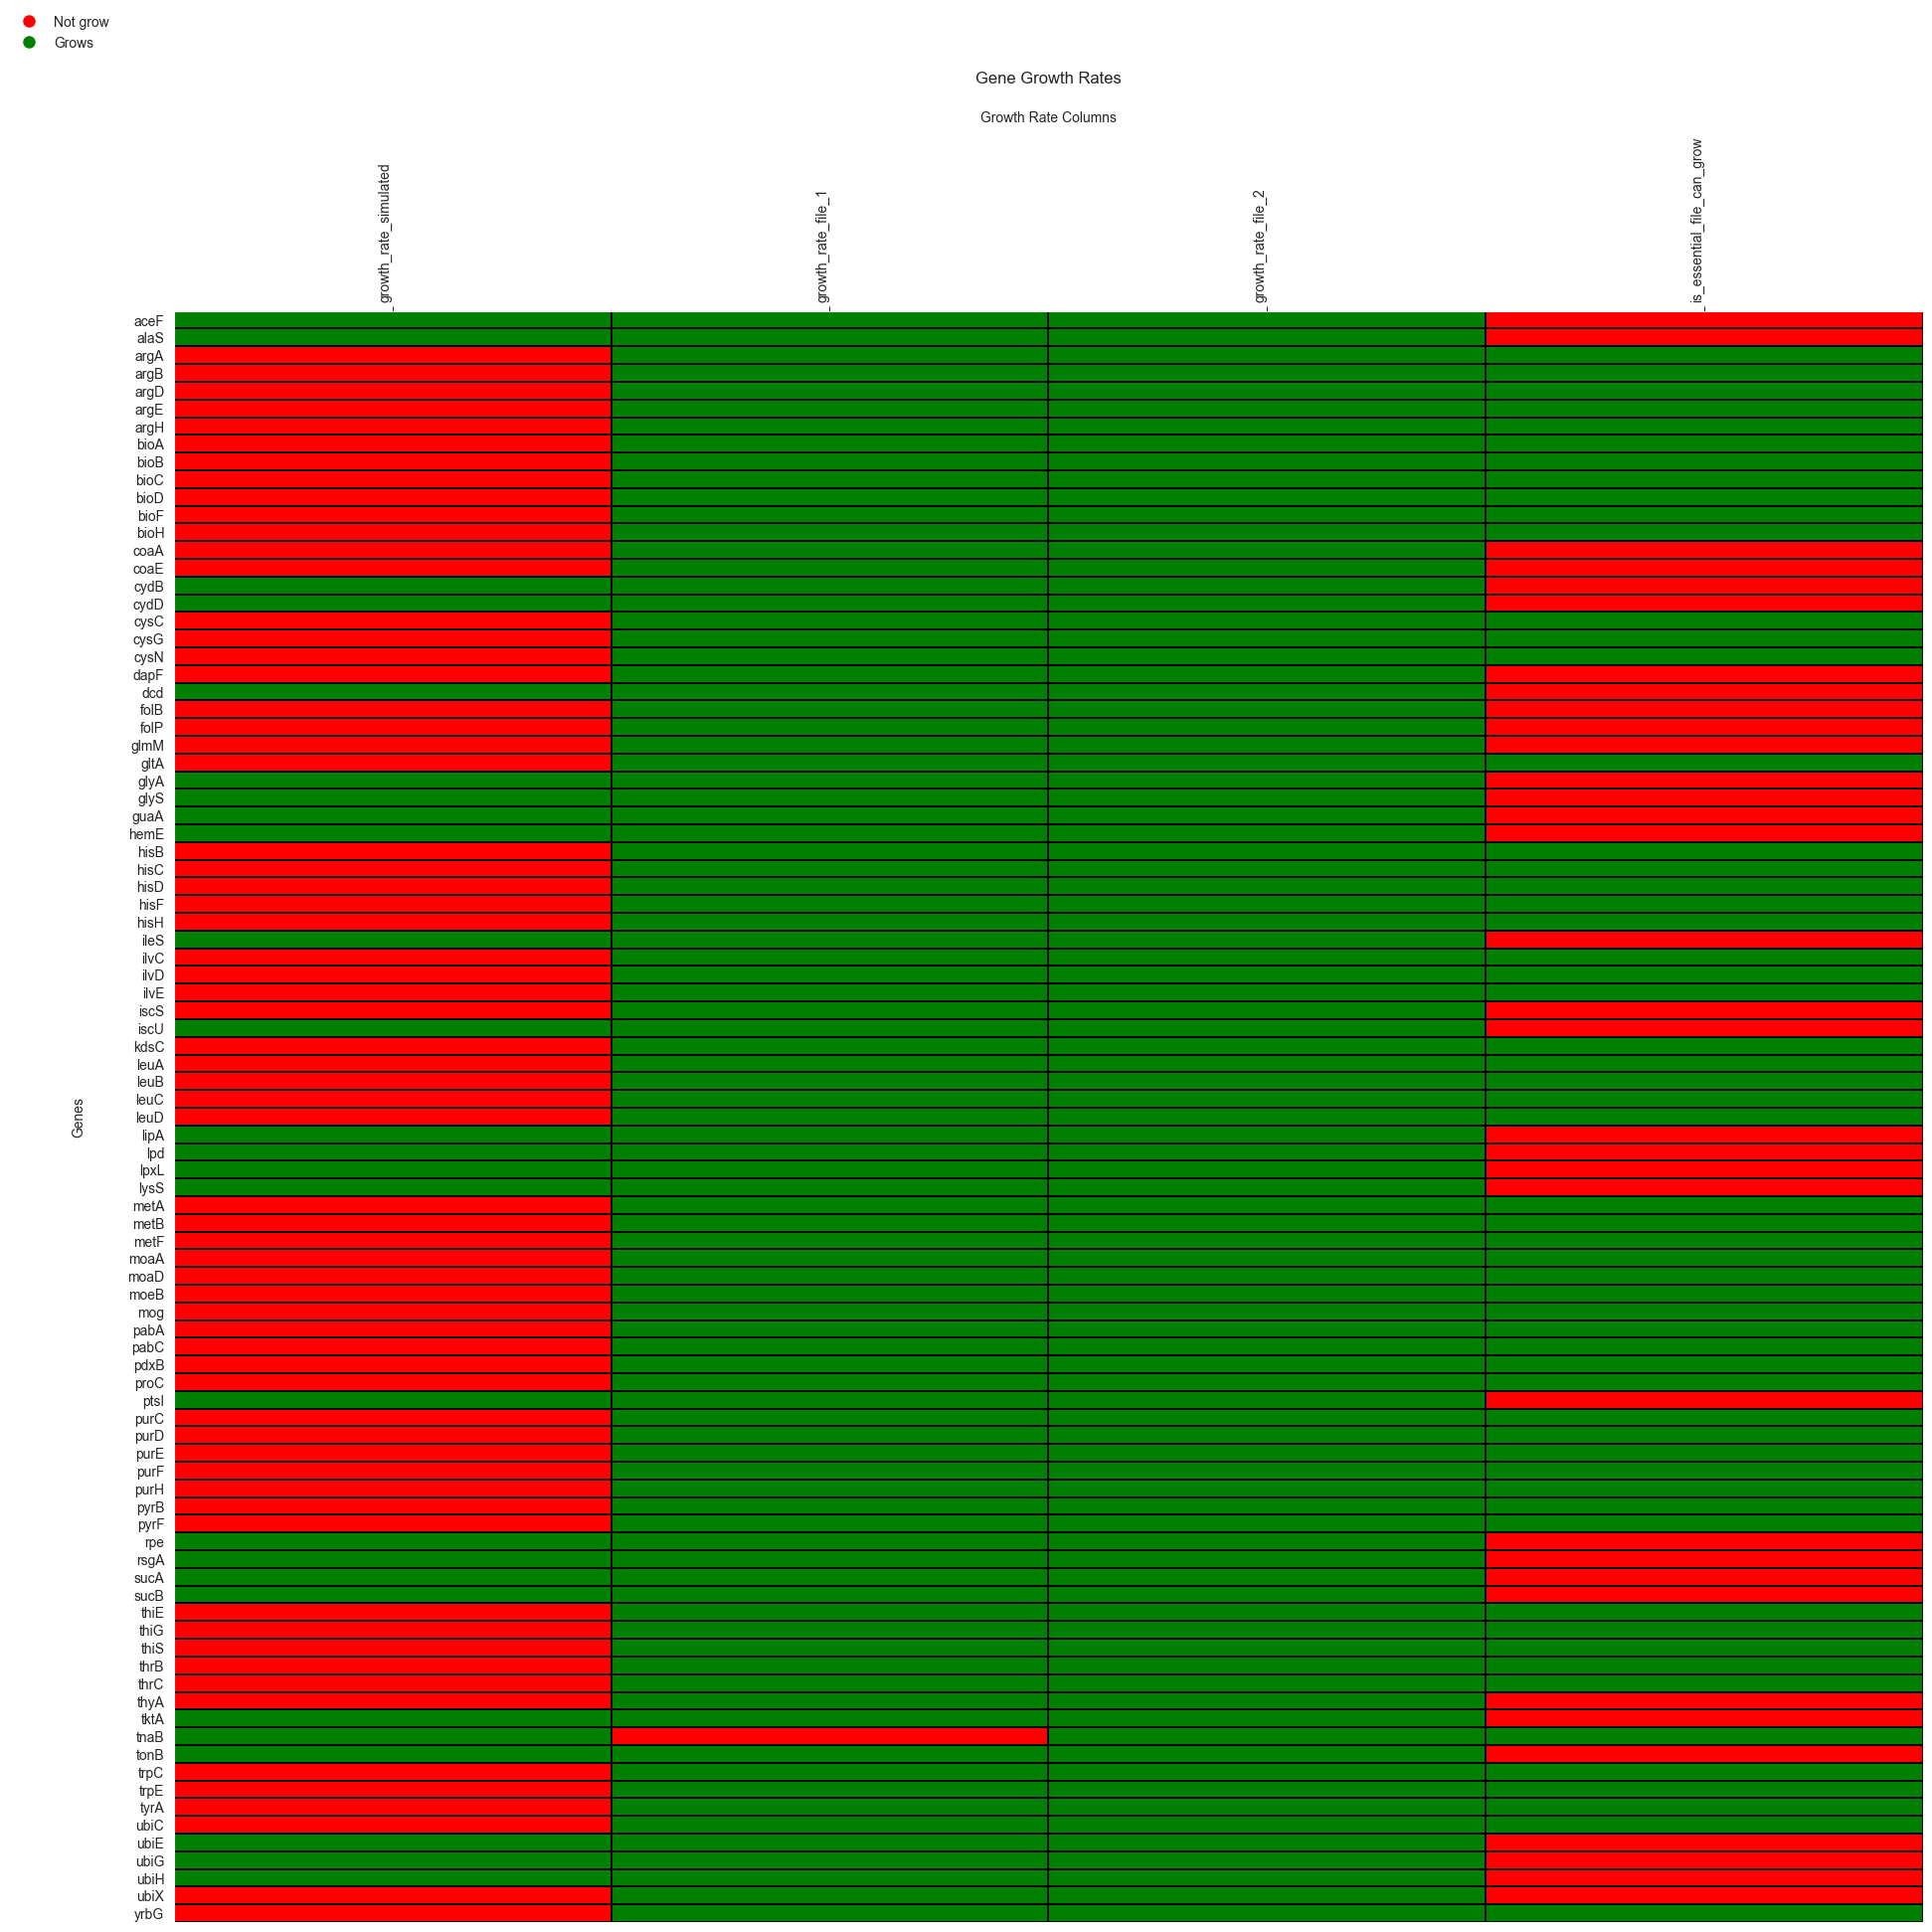

In [19]:
comparison_df_differ = get_uniques(comparison_df.copy())
print(comparison_df_differ)
print("other genes are the same in all growth knockouts between results")
plot_growth_rates(comparison_df_differ)

In [20]:
c = cobra

for name, obj in inspect.getmembers(cobra):
    if inspect.isclass(obj):
        if instance_has_subsystem(obj):
            print(f"Class {name} has an instance with a 'subsystem' attribute.")


Class Reaction has an instance with a 'subsystem' attribute.


In [21]:
models_for_human = {
    "Recon3D": "http://bigg.ucsd.edu/static/models/Recon3D.xml",
    "iAB_RBC_283": "http://bigg.ucsd.edu/static/models/iAB_RBC_283.xml",
    "iAT_PLT_636": "http://bigg.ucsd.edu/static/models/iAT_PLT_636.xml",
    "RECON1": "http://bigg.ucsd.edu/static/models/RECON1.xml",
    "Human-GEM": "https://github.com/SysBioChalmers/Human-GEM/raw/main/model/Human-GEM.xml"
}
for model_n, model_url in models_for_human.items():
    model_human_gem_url = model_url
    model_filename = "models/" + model_n + ".xml"

    if not os.path.exists(model_filename):
        print(f"model '{model_n}' not exists")
        response = requests.get(model_human_gem_url)
        response.raise_for_status() 

        with open(model_filename, 'wb') as file:
            file.write(response.content)
    else:
        print(f"model '{model_n}' exists. not downloading ")

    model_human_gem = cobra.io.read_sbml_model(model_filename)

    reactions_with_subsystems = [reaction for reaction in model_human_gem.reactions if reaction.subsystem]
    if len(reactions_with_subsystems) > 1:

        for reaction in reactions_with_subsystems:
            print(
                f"model name : {model_n} \t\t {reactions_with_subsystems.index(reaction)} /{len(reactions_with_subsystems)} \t\t reaction : {reaction.name} subsytems: {reaction.subsystem}")
    else:
        print(f'model name : {model_n} does not acquire any reaction subsystme')

model 'Recon3D' exists. not downloading 
model name : Recon3D does not acquire any reaction subsystme
model 'iAB_RBC_283' exists. not downloading 
model name : iAB_RBC_283 does not acquire any reaction subsystme
model 'iAT_PLT_636' exists. not downloading 


No objective coefficients in model. Unclear what should be optimized


model name : iAT_PLT_636 does not acquire any reaction subsystme
model 'RECON1' exists. not downloading 
model name : RECON1 does not acquire any reaction subsystme
model 'Human-GEM' exists. not downloading 
model name : Human-GEM 		 0 /12971 		 reaction : ethanol:NAD+ oxidoreductase subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 1 /12971 		 reaction : Ethanol:NADP+ oxidoreductase subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 2 /12971 		 reaction : Acetate:CoA ligase (AMP-forming) subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 3 /12971 		 reaction : Acetate:CoA ligase (AMP-forming) subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 4 /12971 		 reaction : acetyl adenylate:CoA acetyltransferase subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 5 /12971 		 reaction : ATP:acetate adenylyltransferase subsytems: Glycolysis / Gluconeogenesis
model name : Human-GEM 		 6 /12971 		 reaction : (S)-Lactate:NAD

In [22]:
all_models = get_bigg_models()
ecoli_models = [model for model in all_models if 'coli' in model['organism']]
print(f"Found {len(ecoli_models)} E. coli models in BiGG:")

result_of_models = {}

threads = []

for test_model_obj in ecoli_models:
    if "core" in test_model_obj["bigg_id"]:
        continue
    t = DownloadThread(test_model_obj)
    threads.append(t)
print("starting threads")
for t in threads:
    t.start()
print("threads started")
for t in threads:
    t.join()
print("done downloading")

Found 58 E. coli models in BiGG:
starting threads
model models/iAF1260.xml exists. not downloading 
model models/iAF1260b.xml exists. not downloading 
model models/iAPECO1_1312.xml exists. not downloading 
model models/iB21_1397.xml exists. not downloading 
model models/iBWG_1329.xml exists. not downloading 
model models/ic_1306.xml exists. not downloading 
model models/iE2348C_1286.xml exists. not downloading 
model models/iEC042_1314.xml exists. not downloading 
model models/iEC1344_C.xml exists. not downloading 
model models/iEC1349_Crooks.xml exists. not downloading 
model models/iEC1356_Bl21DE3.xml exists. not downloading 
model models/iEC1364_W.xml exists. not downloading 
model models/iEC1368_DH5a.xml exists. not downloading 
model models/iEC1372_W3110.xml exists. not downloading 
model models/iEC55989_1330.xml exists. not downloading 
model models/iECABU_c1320.xml exists. not downloading 
model models/iECB_1328.xml exists. not downloading 
model models/iECBD_1354.xml exists. no

In [23]:
threads = []
for test_model_obj in ecoli_models:
    print(f"now: {ecoli_models.index(test_model_obj)}/{len(ecoli_models)}")
    if "core" in test_model_obj["bigg_id"]:
        continue
    t = OptThread(test_model_obj)
    t.start()
    threads.append(t)
    t.join()
print("done opt")

now: 0/58
now: 1/58
models/iAF1260.xml starting to opt
Single Gene Knockout Results iAF1260:	1261
now: 2/58
models/iAF1260b.xml starting to opt
Single Gene Knockout Results iAF1260b:	1261
now: 3/58
models/iAPECO1_1312.xml starting to opt
Single Gene Knockout Results iAPECO1_1312:	1313
now: 4/58
models/iB21_1397.xml starting to opt
Single Gene Knockout Results iB21_1397:	1337
now: 5/58
models/iBWG_1329.xml starting to opt
Single Gene Knockout Results iBWG_1329:	1328
now: 6/58
models/ic_1306.xml starting to opt
Single Gene Knockout Results ic_1306:	1307
now: 7/58
models/iE2348C_1286.xml starting to opt
Single Gene Knockout Results iE2348C_1286:	1287
now: 8/58
models/iEC042_1314.xml starting to opt
Single Gene Knockout Results iEC042_1314:	1312
now: 9/58
models/iEC1344_C.xml starting to opt
Single Gene Knockout Results iEC1344_C:	1344
now: 10/58
models/iEC1349_Crooks.xml starting to opt
Single Gene Knockout Results iEC1349_Crooks:	1349
now: 11/58
models/iEC1356_Bl21DE3.xml starting to opt

In [24]:
for t in threads:
    result_of_models[t.name] = t.result
simulation_datas = {}
for model_n_temp, data in result_of_models.items():
    s = pd.DataFrame(list(data.items()), columns=['gene', f'growth_rate_simulated_{model_n_temp}'])
    s[f"growth_rate_simulated_{model_n_temp}"] = s[f"growth_rate_simulated_{model_n_temp}"].apply(
        lambda x: 1 if x > 0 else 0)
    simulation_datas[model_n_temp] = s

In [25]:

pd_essentials = pd.read_excel("essentialgenes_list.xlsx", skiprows=1)

pd_essentials = pd_essentials[["Gene", "Essential", "Non-essential", "Unclear"]]

pd_essentials["gene"] = pd_essentials["Gene"]
pd_essentials["Essential"] = pd_essentials["Essential"].astype(bool)
pd_essentials["Non-essential"] = pd_essentials["Non-essential"].astype(bool)
pd_only_unclear = pd_essentials[["gene", "Unclear"]]
pd_only_unclear = pd_only_unclear[pd_only_unclear["Unclear"] == True]
pd_only_unclear["is_essential_file_can_grow"] = pd_only_unclear["Unclear"].apply(lambda x: np.nan if x == True else 2)
pd_only_unclear = pd_only_unclear[["gene", "is_essential_file_can_grow"]]
pd_essentials = pd_essentials[pd_essentials["Unclear"] == False]
pd_essentials = pd_essentials[["gene", "Essential", "Non-essential"]]

pd_essentials["is_essential_file_can_grow"] = pd_essentials["Essential"].apply(lambda x: 0 if x == True else 1)
pd_essentials = pd_essentials[["gene", "is_essential_file_can_grow"]]

pd_essentials = pd.concat([pd_only_unclear, pd_essentials])

comparison_df = pd.merge(experimental_data_1, experimental_data_2, on="gene", how="outer")
comparison_df = pd.merge(pd_essentials, comparison_df, on="gene", how="outer")
comparison_df

gene  is_essential_file_can_grow  growth_rate_file_1  \
0     JW0032                         NaN                 NaN   
1     JW0064                         NaN                 NaN   
2     JW0098                         NaN                 NaN   
3     JW0128                         NaN                 NaN   
4     JW0139                         NaN                 NaN   
...      ...                         ...                 ...   
5839     zwf                         NaN                 1.0   
5840     NaN                         NaN                 NaN   
5841     NaN                         NaN                 NaN   
5842     NaN                         NaN                 NaN   
5843     NaN                         NaN                 NaN   

      growth_rate_file_2  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
...                  ...  
5839                 1.0  
5840                 0.0  
5841                 1.0  
5842                 1.0  
5843                 1.0  

[5844 rows x 4 columns]

Merging dataframes ...
Progress: 57/57
Performing uniquing operation ...
Uniquing completed.
Splitting DataFrame based on 'is_essential_file_can_grow' ...
Plotting ...


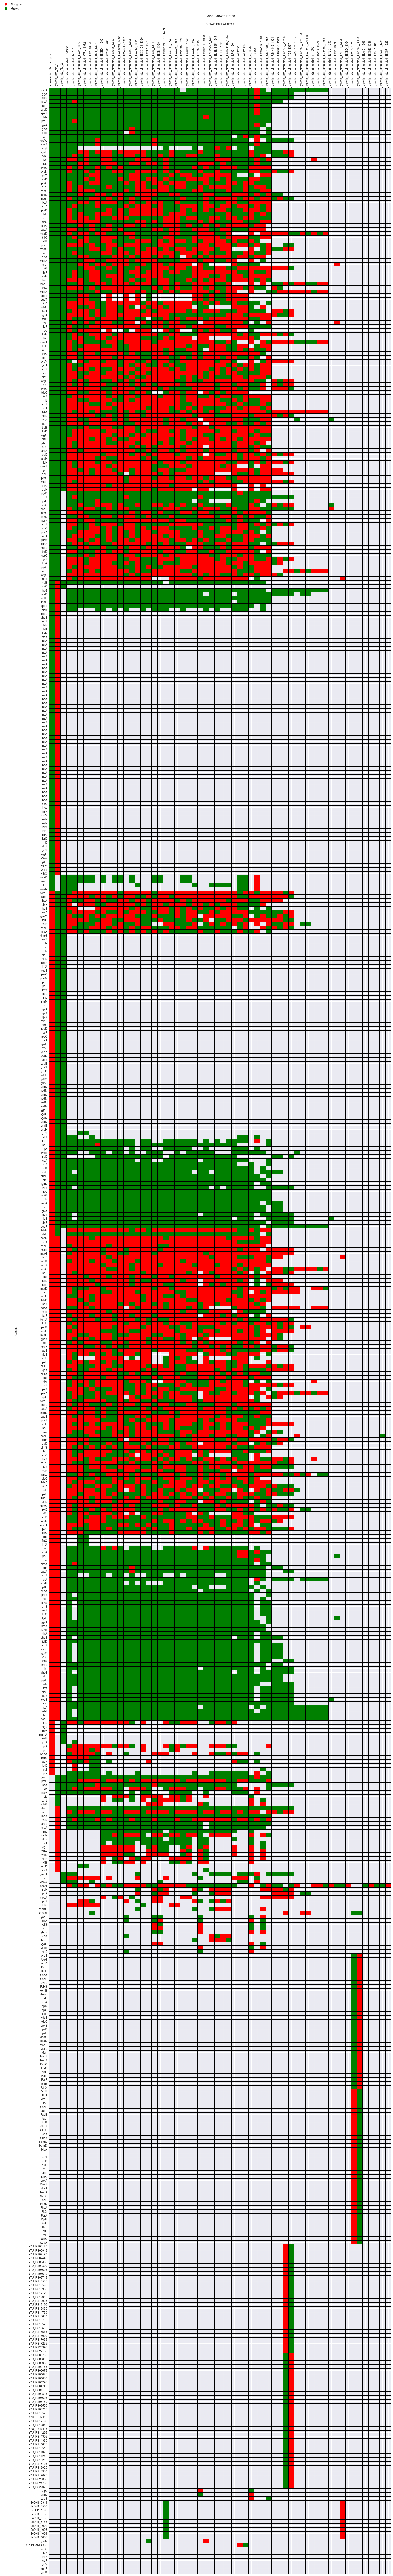

In [26]:
comparison_df_t = comparison_df.copy()

print("Merging dataframes ...")
for i, (key, val) in enumerate(simulation_datas.items(), 1):
    print(f"Progress: {i}/{len(simulation_datas)}",end="\r")
    comparison_df_t = comparison_df_t.merge(val, on="gene", how="outer")
print()
print("Performing uniquing operation ...")
comparison_df_t_total = comparison_df_t.copy()

comparison_df_t_total.to_csv("gene_knockout_comparison.csv", index=False)

comparison_df_t = get_uniques(comparison_df_t)
print("Uniquing completed.")

comparison_df_t['count_1'] = comparison_df_t.apply(lambda row: (row == 1).sum(), axis=1)
comparison_df_t['count_0'] = comparison_df_t.apply(lambda row: (row == 0).sum(), axis=1)
comparison_df_t['count_nan'] = comparison_df_t.apply(lambda row: row.isna().sum(), axis=1)
comparison_df_t['count_not_nan'] = comparison_df_t.apply(lambda row: (~row.isna()).sum(), axis=1)

comparison_df_t['percent_1'] = comparison_df_t['count_not_nan'].replace(0, np.nan)  # Avoid division by zero
comparison_df_t['percent_1'] = comparison_df_t['count_1'] / comparison_df_t['percent_1'] * 100
comparison_df_t['percent_0'] = comparison_df_t['count_not_nan'].replace(0, np.nan)  # Avoid division by zero
comparison_df_t['percent_0'] = comparison_df_t['count_0'] / comparison_df_t['percent_0'] * 100

comparison_df_t['percent_1'].fillna(0)
comparison_df_t['percent_0'].fillna(0)

priority_columns = ["is_essential_file_can_grow", "growth_rate_file_1", "growth_rate_file_2"]

print("Splitting DataFrame based on 'is_essential_file_can_grow' ...")
pd_pos = comparison_df_t[comparison_df_t["is_essential_file_can_grow"] == 1]
pd_neg = comparison_df_t[comparison_df_t["is_essential_file_can_grow"] == 0]
pd_nan = comparison_df_t[comparison_df_t["is_essential_file_can_grow"].isna()]

nan_counts_pos = pd_pos.isna().sum()
nan_counts_neg = pd_neg.isna().sum()
nan_counts_nan = pd_nan.isna().sum()

sorted_columns_pos = nan_counts_pos.sort_values(ascending=False).index.tolist()
sorted_columns_neg = nan_counts_neg.sort_values(ascending=False).index.tolist()
sorted_columns_nan = nan_counts_nan.sort_values(ascending=False).index.tolist()

sorted_columns_pos = [x for x in sorted_columns_pos if x not in priority_columns]
sorted_columns_neg = [x for x in sorted_columns_neg if x not in priority_columns]
sorted_columns_nan = [x for x in sorted_columns_nan if x not in priority_columns]

ordered_columns_pos = priority_columns + sorted_columns_pos[::-1]
ordered_columns_neg = priority_columns + sorted_columns_neg[::-1]
ordered_columns_nan = priority_columns + sorted_columns_nan[::-1]

comparison_df_t_pos = pd_pos[ordered_columns_pos]
comparison_df_t_neg = pd_neg[ordered_columns_neg]
comparison_df_t_nan = pd_nan[ordered_columns_nan]

additional_cols = ["count_not_nan","percent_1","count_1","percent_0","count_0","count_nan"]
must_cols = ["is_essential_file_can_grow","growth_rate_file_1","growth_rate_file_2"]


col_pos = [str(x) for x in [col for col in comparison_df_t_pos.columns if col not in additional_cols+must_cols+["gene"]]]

col_pos = must_cols+["percent_1","count_not_nan"]+col_pos

comparison_df_t_pos = comparison_df_t_pos.sort_values(
    by=col_pos,
    ascending=[False for f in col_pos]
)

col_neg = [str(x) for x in [col for col in comparison_df_t_neg.columns if col not in additional_cols+must_cols+["gene"]]]

col_neg = must_cols+["percent_0","count_not_nan"]+col_neg

comparison_df_t_neg = comparison_df_t_neg.sort_values(
    by=col_neg,
    ascending=[False for f in col_neg]
)

col_nan = [str(x) for x in [col for col in comparison_df_t_nan.columns if col not in additional_cols+must_cols+["gene"]]]

col_nan = must_cols+["count_not_nan"]+col_nan

comparison_df_t_nan = comparison_df_t_nan.sort_values(
    by=col_nan,
    ascending=[False for f in col_nan]
)
comparison_df_t_pos = comparison_df_t_pos.drop(columns=additional_cols)
comparison_df_t_neg = comparison_df_t_neg.drop(columns=additional_cols)
comparison_df_t_nan = comparison_df_t_nan.drop(columns=additional_cols)

print("Plotting ...")
pd_final = pd.concat([comparison_df_t_pos, comparison_df_t_neg, comparison_df_t_nan])
# pd_final = pd_final.sort_values(by=["is_essential_file_can_grow","growth_rate_1","growth_rate_2"], ascending=[False,False,False])

plot_growth_rates(pd_final)

In [27]:

cols_references = ["is_essential_file_can_grow","growth_rate_file_1","growth_rate_file_2"]

cols_models = [str(col) for col in comparison_df_t_total.columns if col not in cols_references+["gene"]]
models_score = {}

refs = {}
for ref in cols_references:
    refs[ref] = comparison_df_t_total[["gene",ref]].dropna()


for col in cols_models:
    temp_pd = comparison_df_t_total[["gene",col]].dropna()
    models_score[col] = {"base_pd":temp_pd,"aggregated_to_refs":{}}
    for ref_name,ref_pd in refs.items():
        models_score[col]["aggregated_to_refs"][ref_name]= {"Accuracy":None,"Precision":None,"Recall":None,"F1 Score":None,"Specificity":None,"df":pd.merge(ref_pd,models_score[col]["base_pd"],on="gene",how="inner")}
        for col_t in [x for x in models_score[col]["aggregated_to_refs"][ref_name]["df"].columns if x !="gene"]:
            models_score[col]["aggregated_to_refs"][ref_name]["df"][col_t] = models_score[col]["aggregated_to_refs"][ref_name]["df"][col_t].astype(bool)
print("done")


done


In [28]:


for key,val in models_score.items():
    name_model = key
    base_pd = val["base_pd"]
    aggrs = val["aggregated_to_refs"]
    for k,v in aggrs.items():
        
        columns_to_check = [col for col in v["df"].columns if col != 'gene']
        print(v["df"])
        total_instances = float(len(v["df"]))
        if total_instances == 0 :
            continue
        v["df"]['true_positive'] = v["df"].apply(true_pos_check, axis=1)
        v["df"]['true_negative'] = v["df"].apply(true_neg_check, axis=1)
        v["df"]['false_positive'] = v["df"].apply(false_pos_check, axis=1)
        v["df"]['false_negative'] = v["df"].apply(false_neg_check, axis=1)
        
        tot_true_pos = float(v["df"]['true_positive'].sum())       
        tot_true_neg = float(v["df"]['true_negative'].sum())       
        tot_false_pos = float(v["df"]['false_positive'].sum())       
        tot_false_neg = float(v["df"]['false_negative'].sum())       
        
        
        
        v["Accuracy"]= (tot_true_pos+tot_true_neg)/total_instances
        v["Precision"]= tot_true_pos/(tot_true_pos+tot_false_pos)
        v["Recall"]= tot_true_pos/(tot_true_pos+tot_false_neg)
        v["F1 Score"]= 2 * ((v["Precision"]*v["Recall"])/(v["Precision"] + v["Recall"]))
        v["Specificity"]= tot_true_neg/(tot_true_pos+tot_false_pos)
    


      gene  is_essential_file_can_grow  growth_rate_simulated_iAF1260
0      aas                        True                           True
1     accA                       False                           True
2     accB                       False                          False
3     accC                       False                           True
4     accD                       False                          False
...    ...                         ...                            ...
1235  znuC                        True                           True
1236  zupT                        True                          False
1237  zupT                        True                          False
1238  zupT                        True                          False
1239  zupT                        True                          False

[1240 rows x 3 columns]
      gene  growth_rate_file_1  growth_rate_simulated_iAF1260
0      aas                True                           True
1     accA 

In [29]:
results_pd_by_model = []

for key , val in models_score.items():
    name_model = key
    base_pd = val["base_pd"]
    aggrs = val["aggregated_to_refs"]
    for k,v in aggrs.items():
        for i in v.keys():
            if i in ["df"]:
                continue
            results_pd_by_model.append({"model":name_model,"referecne":k,"metric":i,"value":v[i]})
pd.DataFrame(results_pd_by_model).to_csv("model_accuracy_results_per_reference_and_metrics.csv",index=False)

In [30]:
# num_rows, num_cols = comparison_df_t_total.shape
# 
# T_comparison_df_t_total = pd.DataFrame(index=comparison_df_t_total.columns, columns=comparison_df_t_total.index)
# for i in range(num_rows):
#     for j in range(num_cols):
#         T_comparison_df_t_total.iloc[j, i] = comparison_df_t_total.iloc[i, j]
#         # print(i,"/",num_rows,"\t",j,"/",num_cols)
#     print(i,"/",num_rows)


In [31]:
# T_comparison_df_t_total.to_csv("result_temp.csv")

In [32]:

cols_references = ["is_essential_file_can_grow","growth_rate_file_1","growth_rate_file_2"]

cols_models = [str(col) for col in comparison_df_t_total.columns if col not in cols_references+["gene"]]
genes_score = {}
for index,row in comparison_df_t_total.iterrows():
    genes_score[row["gene"]] = {}
    for c in cols_references:
        genes_score[row["gene"]][c] = {"Accuracy":None,"Precision":None,"Recall":None,"F1 Score":None,"Specificity":None}
        reference_condition = row[c]
        if str(reference_condition) == str(np.nan) :
            continue
        
        total_instances = 0
        nans_count = 0
        tot_true_pos = 0       
        tot_true_neg = 0       
        tot_false_pos = 0       
        tot_false_neg = 0
        
        for c_model in cols_models:
            temp_cond = row[c_model]
            if str(temp_cond) == str(np.nan):
                nans_count += 1
            else:
                total_instances +=1
        if nans_count == len(cols_models) or total_instances == 0:
            continue
        for c_model in cols_models:
            temp_cond = row[c_model]

            if row[c] == row[c_model] == True:
                tot_true_pos +=1        
            if row[c] == row[c_model] == False:
                tot_true_neg += 1
            if row[c] == False and row[c_model] == True:
                tot_false_pos +=1
            if row[c] == True and row[c_model] == False:
                tot_false_neg +=1
                
        # print(f"tot_true_pos:{tot_true_pos}, tot_true_neg:{tot_true_neg}, tot_false_pos:{tot_false_pos}, tot_false_neg:{tot_false_neg}, total_instances:{total_instances}, nans_count:{nans_count}")
        try:
            genes_score[row["gene"]][c]["Accuracy"]= (tot_true_pos+tot_true_neg)/total_instances
        except:
            pass
        try:
            genes_score[row["gene"]][c]["Precision"]= tot_true_pos/(tot_true_pos+tot_false_pos)
        except:
            pass
        try:
            genes_score[row["gene"]][c]["Recall"]= tot_true_pos/(tot_true_pos+tot_false_neg)
        except:
            pass
        try:
            genes_score[row["gene"]][c]["F1 Score"]= 2 * ((genes_score[row["gene"]][c]["Precision"]*genes_score[row["gene"]][c]["Recall"])/(genes_score[row["gene"]][c]["Precision"] + genes_score[row["gene"]][c]["Recall"]))
        except:
            pass
        try:
            genes_score[row["gene"]][c]["Specificity"]= tot_true_neg/(tot_true_pos+tot_false_pos)
        except:
            pass
    
# print(list(genes_score.items())[:10])    


In [33]:
results_pd_by_gene = []

for key , val in genes_score.items():
    name_gene = key
    for k,v in val.items():
        temp_dict = {"Name" : name_gene,"reference":None}
        
        temp_dict.update(v)
        cond = False
        for k_t , v_t in v.items():
            if v_t is not None:
                cond = True
                break
        if cond == True:
            temp_dict["reference"]=k
            results_pd_by_gene.append(temp_dict)
pd.DataFrame(results_pd_by_gene).to_csv("gene_accuracy_results_per_reference_and_metrics.csv",index=False)